In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from pylab import rcParams
rcParams['figure.figsize'] = 12,8

In [2]:
import pandas as pd
import os

import matplotlib.pyplot as plt

In [3]:
import re

In [6]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import phik

In [7]:
path = "C:/Users/nstolbova/OneDrive - IOC Directory/Робочий стіл/diploma/diploma_datalake/raw_data/open-meteo-50.44N30.48E188m.csv"

df = pd.read_csv(path, header=2)

In [8]:
df['time'] = df['time'].apply(lambda x: pd.to_datetime(pd.Timestamp(x).strftime('%Y-%m-%d %H:%M:%S')))
df = df.set_index('time')
df

,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),rain (mm),snowfall (cm),weather_code (wmo code),pressure_msl (hPa),surface_pressure (hPa),wind_speed_10m (km/h),wind_direction_100m (°),wind_gusts_10m (km/h),is_day (),sunshine_duration (s)
time,,,,,,,,,,,,,
2020-01-01 00:00:00,1.5,94.0,0.6,0.1,0.35,73.0,1009.8,986.5,23.2,298.0,41.8,0,0.0
2020-01-01 01:00:00,1.0,95.0,0.4,0.3,0.00,51.0,1010.4,987.1,25.1,305.0,45.0,0,0.0
2020-01-01 02:00:00,1.5,93.0,0.5,0.2,0.00,51.0,1010.8,987.5,26.6,313.0,47.9,0,0.0
2020-01-01 03:00:00,1.5,92.0,0.4,0.1,0.00,51.0,1011.7,988.4,26.7,317.0,48.6,0,0.0
2020-01-01 04:00:00,1.0,94.0,0.2,0.2,0.00,51.0,1012.8,989.4,25.5,318.0,48.2,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2024-12-26 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2024-12-26 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


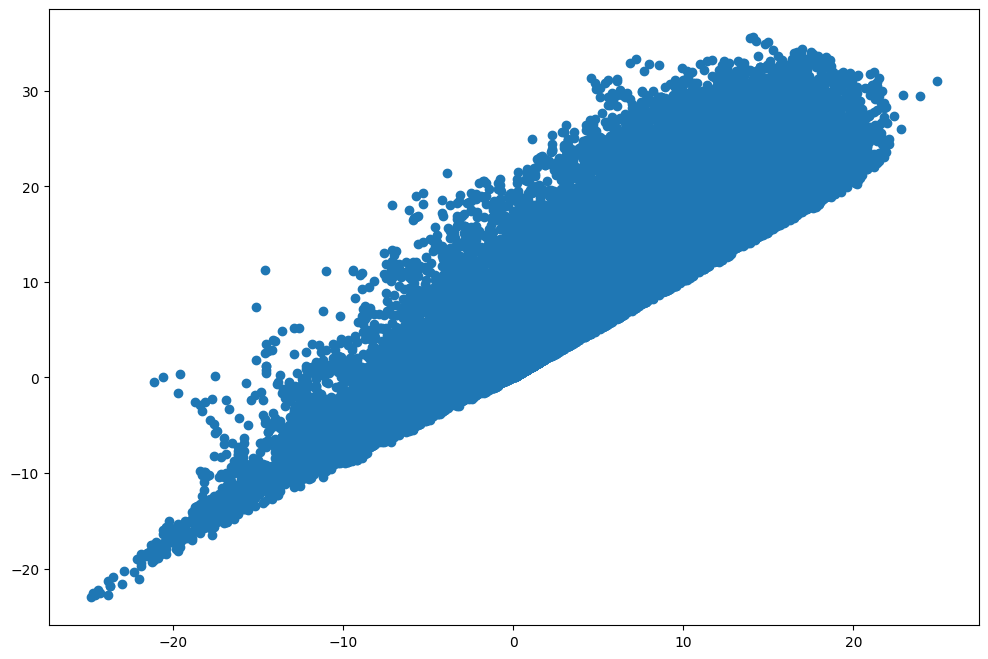

In [9]:
plt.scatter(x='dew_point_2m (°C)', y='temperature_2m (°C)', data=df)

In [ ]:
# plt.plot(df['temperature_2m (°C)'])

In [10]:
df.columns = [i.split(" (")[0] for i in df.columns]
df.columns = [re.split(r"_\d+", i)[0] if i.endswith('m') else i for i in df.columns]
df.columns

Index(['temperature', 'relative_humidity', 'dew_point', 'rain', 'snowfall',
       'weather_code', 'pressure_msl', 'surface_pressure', 'wind_speed',
       'wind_direction', 'wind_gusts', 'is_day', 'sunshine_duration'],
      dtype='object')

In [11]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['week_day'] = df.index.day_of_week
df['year_day'] = df.index.day_of_year

In [12]:
df

,temperature,relative_humidity,dew_point,rain,snowfall,weather_code,pressure_msl,surface_pressure,wind_speed,wind_direction,wind_gusts,is_day,sunshine_duration,year,month,day,hour,week_day,year_day
time,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,1.5,94.0,0.6,0.1,0.35,73.0,1009.8,986.5,23.2,298.0,41.8,0,0.0,2020,1,1,0,2,1
2020-01-01 01:00:00,1.0,95.0,0.4,0.3,0.00,51.0,1010.4,987.1,25.1,305.0,45.0,0,0.0,2020,1,1,1,2,1
2020-01-01 02:00:00,1.5,93.0,0.5,0.2,0.00,51.0,1010.8,987.5,26.6,313.0,47.9,0,0.0,2020,1,1,2,2,1
2020-01-01 03:00:00,1.5,92.0,0.4,0.1,0.00,51.0,1011.7,988.4,26.7,317.0,48.6,0,0.0,2020,1,1,3,2,1
2020-01-01 04:00:00,1.0,94.0,0.2,0.2,0.00,51.0,1012.8,989.4,25.5,318.0,48.2,0,0.0,2020,1,1,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2024,12,26,19,3,361
2024-12-26 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2024,12,26,20,3,361
2024-12-26 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2024,12,26,21,3,361


In [14]:
phik_corr_table = df.phik_matrix()

interval columns not set, guessing: ['temperature', 'relative_humidity', 'dew_point', 'rain', 'snowfall', 'weather_code', 'pressure_msl', 'surface_pressure', 'wind_speed', 'wind_direction', 'wind_gusts', 'is_day', 'sunshine_duration', 'year', 'month', 'day', 'hour', 'week_day', 'year_day']


In [15]:
phik_corr_table

,temperature,relative_humidity,dew_point,rain,snowfall,weather_code,pressure_msl,surface_pressure,wind_speed,wind_direction,wind_gusts,is_day,sunshine_duration,year,month,day,hour,week_day,year_day
temperature,1.000000,0.592231,0.936179,0.056996,0.089790,0.397841,0.438160,0.410734,0.198347,0.299499,0.159618,0.450758,0.501455,0.228576,0.796172,0.186709,0.323457,0.056147,0.792290
relative_humidity,0.592231,1.000000,0.341775,0.054518,0.071194,0.328148,0.233919,0.251753,0.124577,0.193752,0.251427,0.525866,0.573010,0.124699,0.480300,0.096244,0.484596,0.036559,0.485776
dew_point,0.936179,0.341775,1.000000,0.083735,0.066196,0.379690,0.485814,0.455874,0.247612,0.249482,0.176568,0.236377,0.276340,0.228077,0.767765,0.214779,0.054402,0.079134,0.760703
rain,0.056996,0.054518,0.083735,1.000000,0.000000,0.620956,0.073331,0.068948,0.047622,0.023369,0.044602,0.024180,0.027364,0.009077,0.044468,0.018144,0.019226,0.007839,0.045622
snowfall,0.089790,0.071194,0.066196,0.000000,1.000000,0.285085,0.092191,0.098449,0.073330,0.037672,0.058401,0.032835,0.032521,0.022649,0.073311,0.025133,0.019447,0.041916,0.073685
weather_code,0.397841,0.328148,0.379690,0.620956,0.285085,1.000000,0.350712,0.356190,0.259701,0.077866,0.260688,0.071860,0.184630,0.090007,0.313762,0.072366,0.117339,0.020326,0.325133
pressure_msl,0.438160,0.233919,0.485814,0.073331,0.092191,0.350712,1.000000,0.996926,0.354527,0.286821,0.356335,0.112540,0.143829,0.180660,0.471353,0.262278,0.003521,0.103752,0.461939
surface_pressure,0.410734,0.251753,0.455874,0.068948,0.098449,0.356190,0.996926,1.000000,0.355709,0.298212,0.350771,0.099924,0.156048,0.183019,0.460712,0.256283,0.000000,0.096893,0.452563
wind_speed,0.198347,0.124577,0.247612,0.047622,0.073330,0.259701,0.354527,0.355709,1.000000,0.259514,0.953960,0.195331,0.088277,0.110801,0.264223,0.097865,0.248087,0.058899,0.269241
wind_direction,0.299499,0.193752,0.249482,0.023369,0.037672,0.077866,0.286821,0.298212,0.259514,1.000000,0.250358,0.081439,0.073889,0.185544,0.344841,0.193130,0.080486,0.069581,0.353089


In [ ]:
# fig = px.imshow(df.corr(), text_auto=True, color_continuous_scale='Viridis',
#                width=1600, height=800)
# fig.show()
# corr_table = df.corr()[['close', 'growth']]
# phik_corr_table = df.phik_matrix()[['close', 'growth']]

# new_df = pd.concat([corr_table, phik_corr_table], axis=1)[1:]
# new_df.columns = 'linear_corr_close', 'linear_corr_growth', 'phik_corr_close', 'phik_corr_growth'


# fig = make_subplots(rows=2, cols=1, 
#                     subplot_titles=("Correlations with Close price values", "Correlations with Growth value"))

# fig.add_trace(go.Bar(y=new_df.iloc[:, 0],
#                      x=new_df.index,
#                      name=new_df.iloc[:, 0].name,
#                      marker_color="blue"
#                     ),
#               row=1, col=1
#              )

# fig.add_trace(go.Bar(y=new_df.iloc[:, 2],
#                      x=new_df.index,
#                      name=new_df.iloc[:, 2].name,
#                      marker_color="red"
#                     ),
#               row=1, col=1
#              )

# fig.add_trace(go.Bar(y=new_df.iloc[:, 1],
#                      x=new_df.index,
#                      name=new_df.iloc[:, 1].name,
#                      marker_color="blue"
#                     ),
#               row=2, col=1
#              )

# fig.add_trace(go.Bar(y=new_df.iloc[:, 3],
#                      x=new_df.index,
#                      name=new_df.iloc[:, 3].name,
#                      marker_color="red"
#                     ),
#               row=2, col=1
#              )

# fig.update_layout(title=f'Correlations', 
#                   xaxis_tickangle=-45,
#                   width=1300,
#                   height=1000,
#                  )
# fig.update_layout(hovermode="x")
# # fig.update_xaxes(rangeslider_visible=True)

# fig.write_html(f'corellations_visualization_{company.lower()}.html')

# fig.show("notebook")